# Assignment 2: Random forests

`Group`: PA 2 11

`Date`: 30 January 2023

`Group member`: 
- Albin Ekström
- Jonas Nordin

## Task 1: Working with a dataset with categorical features
In this task the assignment is to first read the data, then encode the features into numbers, and lastly combine the steps using pipelines.

### Step 1: Reading the data
Preprocessing of the data, split the data into an X and Y part.

In [3]:
import pandas as pd

TRAINING_DATA_FILE = "adult_train.csv"
TEST_DATA_FILE = "adult_test.csv"

# Read the CSV file.
test_data = pd.read_csv(TEST_DATA_FILE)
train_data = pd.read_csv(TRAINING_DATA_FILE)

# Shuffle the dataset.
test_data = test_data.sample(frac=1.0, random_state=0)
train_data = train_data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X_test = test_data.drop('target', axis=1)
X_train = train_data.drop('target', axis=1)

Y_test = test_data['target']
Y_train = train_data['target']

### Step 2: Encoding the features as numbers
Using DictVectorizer to encode the features as numbers to be able to compute a cross validation score using a classisier. 

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


# Convert training data into dictionaries (as some features are categorical)
X_train_data_as_dicts = X_train.to_dict('records')
X_test_data_as_dicts = X_test.to_dict('records')

# Fit_transform dict data first fits the data (build mapping of categories to column positions, encodes the data)
# Transform converts the data into a matrix
dv = DictVectorizer()
X_train_encoded = dv.fit_transform(X_train_data_as_dicts)

# Cross validation score for the training data using GradientBoostingClassifier
gbc = GradientBoostingClassifier()
train_cross_val_score = cross_val_score(gbc, X_train_encoded, Y_train)
print("Cross validation score using GradientBoostingClassifier:", train_cross_val_score)

# As the mapping of data is already done when the train data was 'fitted' only the
# transformation is needed to encode the test-data
X_test_encoded = dv.transform(X_test_data_as_dicts)

# Compute the accuracy on the test set using GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_encoded, Y_train)
Y_pred = gbc.predict(X_test_encoded)
print("Accuracy score on the test set:", accuracy_score(Y_test, Y_pred))


Cross validation score using GradientBoostingClassifier: [0.86319668 0.86517199 0.8659398  0.86624693 0.86762899]
Accuracy score on the test set: 0.8711381364781033


### Step 3: Combining the steps
Combine step 1 and 2 by using a pipline to do the exact same thing.

In [16]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
  DictVectorizer(),
  GradientBoostingClassifier()
)

# Train the pipeline model
pipeline.fit(X_train_data_as_dicts, Y_train)

# Use the pipeline to predict data
Y_pred = pipeline.predict(X_test_data_as_dicts)

# Print the accuracy score
print("Accuracy score on the test set using the pipline:", accuracy_score(Y_test, Y_pred))

Accuracy score on the test set using the pipline: 0.8711381364781033


As the prediction using the pipeline gets the same accuracy score as in step 2, hence we know the `model works as it should`.

## Task 2: Decision trees and random forests
Investigate how different hyperparameters impact the resulting score of the model.

### Underfitting and overfitting in random forest classifiers

In [28]:
from sklearn.tree import DecisionTreeClassifier

max_depths = range(1,20)
test_scores = []
train_scores = []

for i in max_depths:
    pipeline = make_pipeline(
        DictVectorizer(),
        DecisionTreeClassifier(max_depth=i)
    )
    
    pipeline.fit(X_train_data_as_dicts, Y_train)
    
    train_score = pipeline.score(X_train_data_as_dicts, Y_train)
    test_score = pipeline.score(X_test_data_as_dicts, Y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"Score with a max depth of {i}: Test - {test_score}, Training - {train_score}")

Score with a max depth of 1: Test - 0.7637737239727289, Training - 0.7591904425539756
Score with a max depth of 2: Test - 0.8306615072784227, Training - 0.8282300912134148
Score with a max depth of 3: Test - 0.8447884036607088, Training - 0.8438930008292128
Score with a max depth of 4: Test - 0.8447884036607088, Training - 0.8438930008292128
Score with a max depth of 5: Test - 0.8522818008721823, Training - 0.8519701483369675
Score with a max depth of 6: Test - 0.8575026104047663, Training - 0.8570989834464543
Score with a max depth of 7: Test - 0.8568883975185799, Training - 0.8583888701206965
Score with a max depth of 8: Test - 0.8568883975185799, Training - 0.8605693928319155
Score with a max depth of 9: Test - 0.8586081935999017, Training - 0.8639476674549308
Score with a max depth of 10: Test - 0.861249309010503, Training - 0.8693836184392372
Score with a max depth of 11: Test - 0.8603279896812235, Training - 0.873744663861675
Score with a max depth of 12: Test - 0.858485351022664

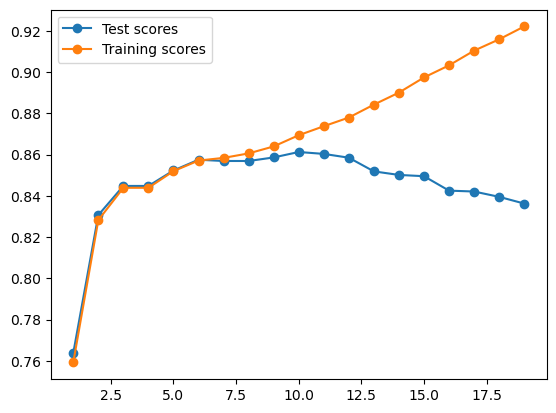

In [31]:
import matplotlib.pyplot as plt


# Plot the training and test scores
plt.plot(max_depths, test_scores, '-o', label="Test scores")
plt.plot(max_depths, train_scores, '-o', label="Training scores")
plt.legend()
plt.show()

As the figure above shows, a similar effect can be seen in the previous assignment where the score for the training and test set deviate. The point of deviation would also be where an optimal value for the max_depth can be found.

### Underfitting and overfitting in random forest classifiers

In [156]:
from sklearn.ensemble import RandomForestClassifier

max_depths = range(1,20)
ensamble_sizes = [1, 10, 50, 100, 150, 200, 250, 300]
test_scores = {}
train_scores = {}

for ensamble_size in ensamble_sizes:
    print(f"Current ensamble size - {ensamble_size}")
    for i in max_depths:
        pipeline = make_pipeline(
            DictVectorizer(),
            RandomForestClassifier(n_estimators=ensamble_size ,max_depth=i, n_jobs=-1)
        )
        
        pipeline.fit(X_train_data_as_dicts, Y_train)
        
        train_score = pipeline.score(X_train_data_as_dicts, Y_train)
        test_score = pipeline.score(X_test_data_as_dicts, Y_test)
        
        train_scores.setdefault(ensamble_size, []).append(train_score)
        test_scores.setdefault(ensamble_size, []).append(test_score)

Current ensamble size - 1
Current ensamble size - 10
Current ensamble size - 50
Current ensamble size - 100
Current ensamble size - 150
Current ensamble size - 200
Current ensamble size - 250
Current ensamble size - 300


#### Create a heat map of accuracy, esamble size and max depth

Text(0.5, 23.52222222222222, 'Max depth')

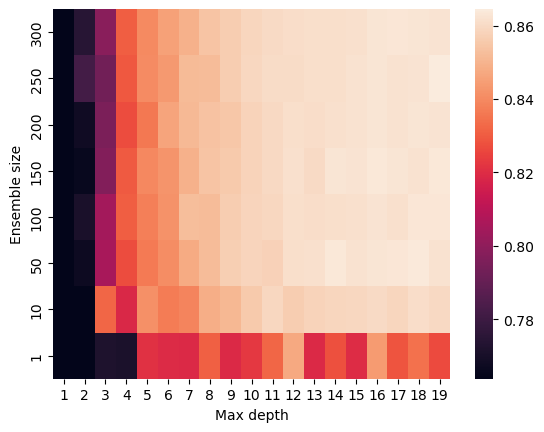

In [108]:
import seaborn

# Plot heatmap of random forest classifier results with different ensemble sizes
test_scores_df = pd.DataFrame(data=test_scores, index=range(1,20)).transpose()
test_scores_df = test_scores_df.iloc[::-1]

ax = seaborn.heatmap(test_scores_df)

ax.set_ylabel('Ensemble size')
ax.set_xlabel('Max depth')

This heatmap gives us an indication of what ensamble size of the random forrests the model ''stabalizes''.

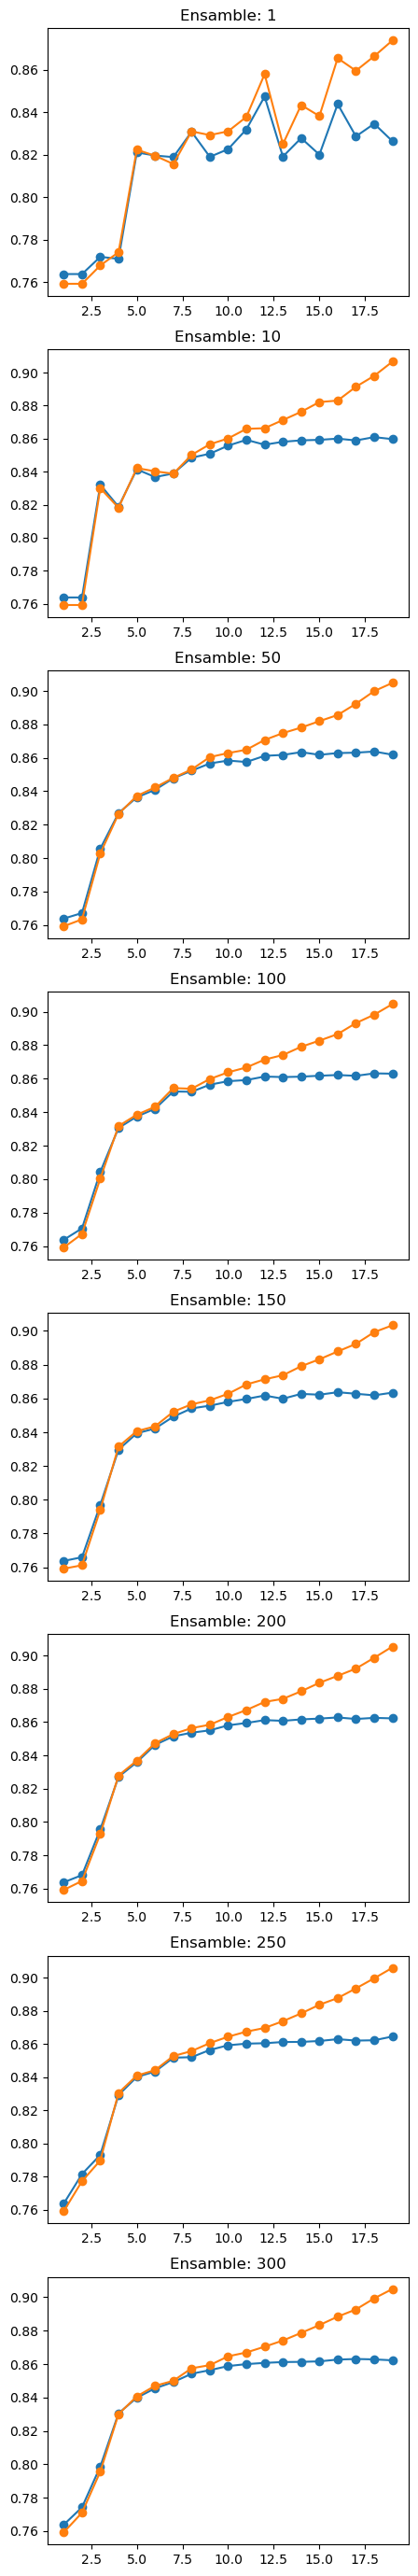

In [134]:
fig, axs = plt.subplots(8, 1, figsize=(5, 35))

for i in range(0,len(ensamble_sizes)):
    axs[i].plot(max_depths, test_scores[ensamble_sizes[i]], '-o', label="Test scores")
    axs[i].plot(max_depths, train_scores[ensamble_sizes[i]], '-o', label="Test scores")
    axs[i].set_title(f'Ensamble size: {ensamble_sizes[i]}')
    
    
# Orange: Training scores
# Blue: Test scores

### Questions:

``What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?``

The difference between using a single decision tree and a random forest with ensemble size 1 is that the single decision tree will be trained on the whole given dataset and on all of the features it contains. The random forest model works slightly differently in its approach of training the trees in the forest (in this case a single tree). The difference is that the random forests only use a bootstrapped sample of the dataset and a random feature selection to train each individual tree, making the forest less prone to overfitting as each tree captures different patterns in its given data set. What then happens if a forest only contains one tree is that this tree will only be trained on a random bootstrapped sample of the data with a random selection of the features, the single tree will find patterns of this random data selection, thus the difference in score between the models.


``What happens with the curve for random forests as the ensemble size grows?``

As the size of the forest grows, its curve of it will be more smooth and show a more representative accuracy of the used ensemble size as a function of max_depth. This occurs because, with a larger forest, each tree in the model will have less impact on the final averaged prediction. The accuracy of a model trained with a fixed max_depth will be less dependent on what random bootstrapped data and feature selection each tree was trained as the ensemble size gets larger. This, in practice, means that if we were to generate the curves shown above again, the curves with a small ensemble size may look very different compared to the ones already generated and the ones with a larger forest size will still look the same.


``What happens with the best observed test set accuracy as the ensemble size grows?``

As the size of the forest grows, the prediction made by the model will improve as it will be based on a larger amount of trees trained on different samples of the data and different sets of feature selections. An average of the predictions made by each tree that has captured different patterns of the data will then be better as the number of trees in the forest grows. However, beyond a certain ensemble size, the improvement in accuracy may become negligible, and increasing the ensemble size further may not lead to significant improvement in accuracy and may cause overfitting instead.





``What happens with the training time as the ensemble size grows?``

The training time grows as the ensemble size grows. The training time of Random Forest has training time complexity: **O(n•log(n)•d•k)** [1], where n = number of samples in the dataset, k = number of Decision Trees, d = number of dimensions of the data. As we can see the time complexity grows with the number of trees, k, hence also the real-time training time.

Intuitively this also makes sense, because each tree requires time to train, hence adding more trees will lead to longer training time.

[1] Source: https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770



## Task 3: Feature importances in random forest classifiers
In this task we will utilize a pipline from the previuos task with a set of hyperparameters that gave a good score. We will then train the model on the data and reason about the features and their importances to the model.

In [149]:
# Good RandomForest result from above
pipeline = make_pipeline(
    DictVectorizer(),
    RandomForestClassifier(n_estimators=150 ,max_depth=10, n_jobs=-1)
)

# Train the model on the data
pipeline.fit(X_train_data_as_dicts, Y_train)

# Capture the feature names and their importances
dv = pipeline.steps[0][1]
rfc = pipeline.steps[1][1]
feature_names = dv.feature_names_
feature_importances = rfc.feature_importances_

# Zip the feature names with its respective feature and sort this list by importance
features = list(zip(feature_names, feature_importances))
features.sort(key=lambda f: f[1], reverse=True)

# Print the list of sorted features by importance
print(features[:15])

[('capital-gain', 0.16077165287250303), ('marital-status=Married-civ-spouse', 0.15069659137615127), ('education-num', 0.11193282622351246), ('relationship=Husband', 0.0931451253065781), ('marital-status=Never-married', 0.05753050234736403), ('age', 0.0548814147127113), ('hours-per-week', 0.0431373366895854), ('capital-loss', 0.03459940285347571), ('occupation=Exec-managerial', 0.02571525593470643), ('relationship=Not-in-family', 0.024677444539440454), ('education=Bachelors', 0.02093238527759021), ('occupation=Prof-specialty', 0.020342406355447085), ('relationship=Own-child', 0.019945399618250176), ('sex=Female', 0.01778912734227926), ('relationship=Wife', 0.017633039841469984)]


<BarContainer object of 15 artists>

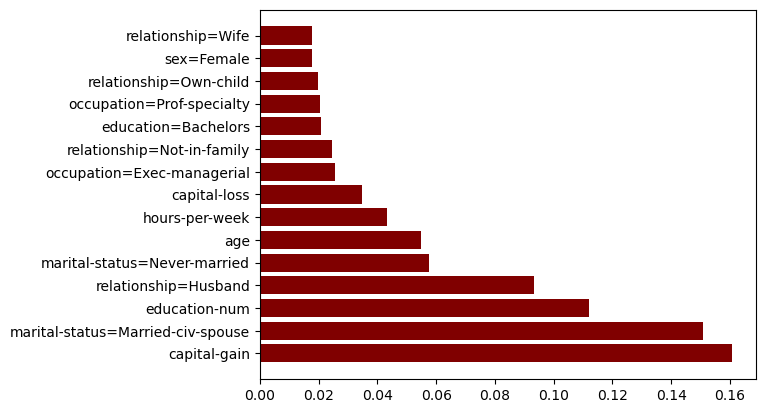

In [160]:
# Print a barplot of the feature-importances
key = list(zip(*features[:15]))[0]
height = list(zip(*features[:15]))[1]

plt.barh(key, height, color ='maroon')

### An alternative way to compute some sort of importance score of individual features
An alternative method to compute the feature importance is to shuffle or remove a feature from the dataset, then train the model and see if the performance of the model decreases. If the performance decreases significantly after shuffling or removing the feature, it is an indication that the feature was important for the model to make accurate predictions. By repeating this process for each feature, we can compute a more reliable feature importance score that is not biased towards features with high numerical values (this occurs because features with high numerical values will have a larger impact on where the feature distinguishes the classes, even if they don't have a significant impact on the final predictions). E.g. if we have two features, one with high and one with low numerical values, the one with high values will receive a higher importance score which can lead to inaccurate assumptions about the model.

The procedure would be to create a baseline score for the model, then drop a feature and calculate the new performance score, and compare it with the baseline - repeating this for every feature we should get the importance score. However, this method is computationally heavy as it requires retraining the model for each feature. Therefore, it is not recommended to use this method for large datasets or models with high computational requirements (i.e. models which will take time to train). But for smaller datasets, using this method we can get a more reliable, but more heavily computed feature importance than calling feature_importances_ from the model.